In [2]:
import numpy as np
#import pandas as pd
import matplotlib.pyplot as plt

In [586]:
class MLP:
    def __init__(self, input_layer_len, output_layer_len,hidden_layers_len,activation_function):
        self.activation_function = activation_function
        self.input_layer = np.zeros((1,input_layer_len))
        self.output_layer = np.zeros((1,output_layer_len))
        self.weights=[]
        
        self.weights.append(np.random.random((hidden_layers_len[0],input_layer_len)))
        
        for i in range(1,len(hidden_layers_len)):
            self.weights.append(np.random.random((hidden_layers_len[i],hidden_layers_len[i-1])))
            
        self.weights.append(np.random.random((output_layer_len,hidden_layers_len[-1])))
        
        self.biases=[]
        
        for i in range(len(hidden_layers_len)):
            self.biases.append(np.zeros((1,hidden_layers_len[i])))
            
        
        self.biases.append(np.zeros((1,output_layer_len,1)))
        
        self.hidden_layers=[]
        
        for i in range(len(hidden_layers_len)):
            self.hidden_layers.append(np.zeros((hidden_layers_len[i],1)))
        
        #self.hidden_layers.append(np.zeros((output_layer_len,1)))
        #self.hidden_layers=[mlp.input_layer]+self.hidden_layers
        
    def calculate(self,input_layer,memory=False):
        self.input_layer=input_layer.copy()
        
        if(memory):
            for i in range(len(self.weights)-1):
                self.hidden_layers[i]=input_layer.dot(self.weights[i].T)+self.biases[i]
                input_layer=self.activation_function(self.hidden_layers[i])
                
        else:    
            for i in range(len(self.weights)-1):
                input_layer=self.activation_function(input_layer.dot(self.weights[i].T)+self.biases[i])
                
                
        output_layer=(input_layer.dot(self.weights[-1].T)+self.biases[-1])[0]
        self.output_layer=output_layer.copy()
        #self.hidden_layers[-1]=output_layer.copy()
        
        return(output_layer)
        
    def train(self,input_layer,true_output_layer,rate=0.1):
        
        #feedforward
        output_layer=self.calculate(input_layer,memory=True)
        error=sum((true_output_layer-output_layer)**2)/true_output_layer.shape[0]
        print(error)
        #output error identity function
        errors=[0 for i in range(len(self.weights)-1,-1,-1)]
        errors[-1]=(true_output_layer-output_layer)*output_layer
        for i in range(len(self.weights)-2,-1,-1):
            #derivative of sigmoid
            errors[i]=weights[i].dot(error.T)*sigmoid(hidden_layers[i])*(1-sigmoid(hidden_layers[i]))
        
        #gradient descent
        for i in range(len(self.weights)-1,-1,-1):
            self.weights[i]=self.weights[i]-rate
        

In [4]:
def sigmoid(x):
    return(1/(1 + np.exp(-x)))

In [5]:
def sigmoid_derivative(x):
    return(sigmoid(x)*(1-sigmoid(x)))

In [372]:
sigmoid_derivative(np.ones((1,2)))

array([[0.19661193, 0.19661193]])

In [42]:
test = np.loadtxt("mio1/regression/square-simple-training.csv", delimiter=',', skiprows=1, usecols=range(1,3))

In [587]:
X=test[:,0].reshape(-1,1)

In [588]:
Y=test[:,1].reshape(-1,1)

In [49]:
X.shape

(100, 1)

In [700]:
mlp=MLP(1,1,[3,4,5],sigmoid)

input_layer=X

true_output_layer=Y

rate=0.01

In [690]:
#feedforward
output_layer=mlp.calculate(input_layer,memory=True)
error=sum((true_output_layer-output_layer)**2)/true_output_layer.shape[0]
print(error)

old_weights=mlp.weights.copy()


#output error identity function
errors=[[0]*len(mlp.weights) for x in range(true_output_layer.shape[0])]
for x in range(output_layer.shape[0]):
    errors[x][-1]=(output_layer[x]-true_output_layer[x].T)*output_layer[x]
    
    for i in range(len(mlp.weights)-2,-1,-1):     #derivative of sigmoid
        errors[x][i]=mlp.weights[i+1].T.dot(errors[x][i+1])*sigmoid_derivative(mlp.hidden_layers[i][x])

#gradient
#mlp.hidden_layers=[mlp.input_layer]+mlp.hidden_layers
for l in range(0,len(mlp.weights)-1):
    gradient=sum([mlp.activation_function(mlp.hidden_layers[-1][x].reshape((-1,1))) for x in range(output_layer.shape[0])]).dot(errors[x][l+1].reshape((1,-1)))
    #print(gradient)
    mlp.weights[l]=mlp.weights[l]-gradient*rate/output_layer.shape[0]
    gradient=sum([errors[x][l].reshape((1,-1)) for x in range(output_layer.shape[0])])
    
    mlp.biases[l]=mlp.biases[l]-gradient*rate/output_layer.shape[0]
      

#mlp.hidden_layers.pop(0)

gradient=sum([errors[x][-1].reshape((-1,1)).dot(mlp.activation_function(mlp.hidden_layers[-1][x].reshape((1,-1)))) for x in range(output_layer.shape[0])])
#print(gradient)
mlp.weights[-1]=mlp.weights[-1]-gradient*rate/output_layer.shape[-1]
gradient=sum([errors[x][-1].reshape((1,-1)) for x in range(output_layer.shape[0])])
mlp.biases[-1]=mlp.biases[-1]-gradient*rate/output_layer.shape[0]


print([old_weights[x]-mlp.weights[x] for x in range(len(mlp.weights))])




[10237.29736753]


ValueError: operands could not be broadcast together with shapes (3,1) (5,4) 

In [691]:
[mlp.weights[x].shape for x in range(len(mlp.weights))]

[(3, 1), (4, 3), (5, 4), (1, 5)]

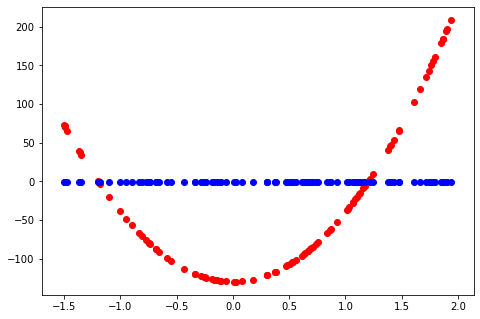

In [675]:
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(input_layer, true_output_layer, color='r')
ax.scatter(input_layer,output_layer,color="b")

In [696]:
[mlp.hidden_layers[x].shape for x in range(3)]

[(3, 1), (4, 1), (5, 1)]

In [697]:
[errors[0][x].shape for x in range(len(errors[0]))]

[(3,), (4,), (5,), (1,)]

In [698]:
[mlp.weights[x].shape for x in range(len(mlp.weights))]

[(3, 1), (4, 3), (5, 4), (1, 5)]

In [699]:
mlp.output_layer.shape

(1, 1)

In [445]:
#warstwa przyklad neuron
mlp.hidden_layers[0][0]

array([-1.4813543, -1.4813543, -1.4813543, -1.4813543])

In [324]:
mlp.train(X,Y)

[[6.68602948e-01]
 [6.10105933e-01]
 [3.47440350e-04]
 ...
 [6.10151439e-01]
 [6.10194959e-01]
 [6.10171751e-01]]


In [ ]:
pd.read_csv

In [107]:
#test=pd.read_csv("mio1/regression/steps-large-training.csv",delimiter=",")

In [38]:
test = np.loadtxt("mio1/regression/square-simple-training.csv", delimiter=',', skiprows=1, usecols=range(1,3))

In [40]:
test

array([[-1.71542658e-01, -1.27351580e+02],
       [ 2.52005474e-02, -1.29942844e+02],
       [-1.36899138e+00,  3.86723671e+01],
       [ 1.90738970e+00,  1.97432191e+02],
       [ 1.11293711e-02, -1.29988852e+02],
       [ 1.85151809e+00,  1.78530731e+02],
       [ 1.60714217e+00,  1.02461536e+02],
       [ 7.39925693e-01, -8.07258972e+01],
       [ 1.89838314e+00,  1.94347268e+02],
       [ 6.65933726e-01, -9.00879046e+01],
       [-3.33004761e-01, -1.20019705e+02],
       [-2.86381131e-01, -1.22618726e+02],
       [-1.05301060e-01, -1.29002052e+02],
       [ 1.24642471e+00,  9.82171130e+00],
       [-1.36372228e+00,  3.73764614e+01],
       [ 1.12078385e+00, -1.69459202e+01],
       [ 8.70468906e-01, -6.18055496e+01],
       [-9.00574844e-01, -5.70068456e+01],
       [-5.86192127e-01, -9.90740912e+01],
       [ 3.00445271e-01, -1.21875938e+02],
       [ 8.64625461e-01, -6.27180531e+01],
       [ 1.93986019e+00,  2.08675181e+02],
       [ 1.15840494e+00, -9.22882029e+00],
       [ 4.

In [109]:
test=test[["x","y"]]

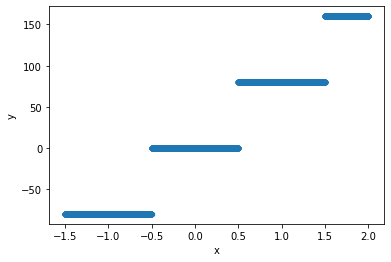

In [114]:
test.plot.scatter(x="x",y="y")

In [263]:
test_mlp=MPL(1,1,[5],sigmoid)

In [264]:
test_mlp.calculate(X)

array([[0.92611473],
       [3.68774105],
       [2.40454252],
       ...,
       [3.46152408],
       [3.2786449 ],
       [3.37272737]])

In [127]:
X=np.vstack(test["x"].to_numpy())

In [177]:
Y_hat=test_mpl.output_layer

In [178]:
Y=np.vstack(test["y"].to_numpy())

In [179]:
sum((Y-Y_hat)**2)

array([70884723.61747867])

In [193]:
np.random.random((1,5))

array([[0.79744999, 0.46417824, 0.5293035 , 0.29351545, 0.87100363]])

In [246]:
Y.min()

-80

In [243]:
test_mlp=MPL(1,1,[5],sigmoid)

test_mlp.hidden_layers[0]=np.array([[1000,1,1,1,1]])
test_mlp.hidden_layers_bias[0]=np.array([[1,1,1,1,1]])


test_mlp.calculate(X)
Y_hat=test_mlp.output_layer

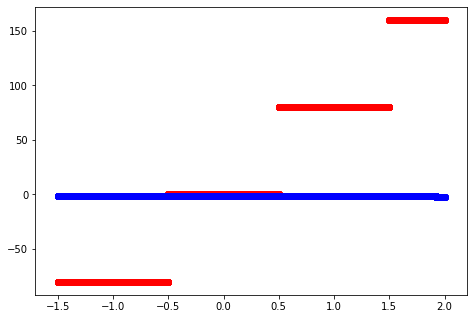

In [258]:
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(X, Y, color='r')
ax.scatter(X,Y_hat,color="b")